# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [1]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, accuracy_score


c:\Users\phiph\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

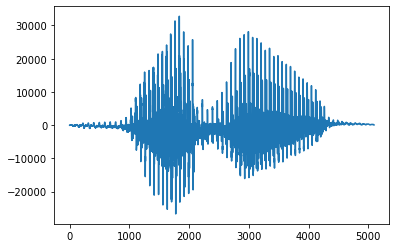

In [2]:
from scipy.io import wavfile

file_path = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

In [3]:
print(np.fft.ifft(np.log(np.abs(np.fft.fft(wav_data)))).shape)

(5098,)


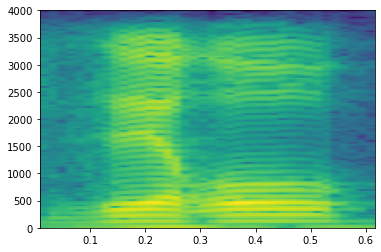

In [4]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

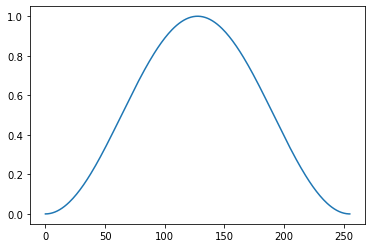

In [5]:
plt.plot(np.hanning(256))

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [6]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !

    window = np.hanning(window_size)
    signal_length = len(wav_data)
    num_frames = 1 + int(np.floor((signal_length - window_size) / window_shift))
    
    cepstral_coeffs = []
    for i in range(num_frames):
        start = i * window_shift
        end = start + window_size
        
        # Extract the current frame from the signal
        frame = wav_data[start:end]
        
        # Apply the Hanning window to the frame
        frame = frame*window
        
        # Compute the FFT of the frame
        spectrum = np.fft.fft(frame)
        
        # Compute the cepstral coefficients
        cepstral_coeff = np.fft.ifft(np.log(np.abs(spectrum))).real
        
        cepstral_coeffs.append(cepstral_coeff[:cepstral_order])
    
    cepstral_coeffs = np.array(cepstral_coeffs)
    
    return cepstral_coeffs
    
    

In [7]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [8]:
5098 // 128 - 1

38

In [9]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $C (l_X \times l_Y)$ such that $C(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $D (l_X \times l_Y)$ such that $D(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $D(i,i)$ then $D(i+1,i), \dots D(l_X,i)$ and $D(i,i+1), D(i,i+2), \dots D(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```D```).

In [10]:
from scipy.spatial.distance import cdist

def time_alignment(x, y, gamma):
    #Calculation of the similarity matrix
    D = cdist(x, y, metric='euclidean')
    #Initialization of the cumulative distance matrix
    C_D= np.zeros((len(x), len(y)))
    #Calculation of the matrix of cumulative distances whith diagonal weighting gamma
    for i in range(len(x)):
        for j in range(len(y)):
            if i == 0 and j == 0:
                C_D[i, j] = C_D[i, j]
            elif i == 0:
                C_D[i, j] = D[i, j] + C_D[i, j-1]
            elif j == 0:
                C_D[i, j] = D[i, j] + C_D[i-1, j]
            else:
                C_D[i, j] =  min(C_D[i-1, j]+D[i, j], C_D[i-1, j-1]+D[i, j]*gamma, C_D[i, j-1]+D[i, j]) 
    #Bactracking:
    l_X = len(x) - 1
    l_Y = len(y) - 1
    distance = C_D[l_X, l_Y]
    path = [(l_X, l_Y)]
    while l_X > 0 or l_Y > 0:
        if l_X == 0:
            l_Y -= 1
        elif l_Y == 0:
            l_X -= 1
        else:
            if C_D [l_X-1, l_Y] == min(C_D[l_X-1, l_Y-1], C_D[l_X-1, l_Y], C_D[l_X, l_Y-1]):
                l_X -= 1
            elif C_D[l_X, l_Y-1] == min(C_D[l_X-1, l_Y-1], C_D[l_X-1, l_Y], C_D[l_X, l_Y-1]):
                l_Y -= 1
            else:
                l_X -= 1
                l_Y -= 1
        path.append((l_X, l_Y))
    path.reverse()
    
   # Construct the alignment path matrix M
    M = np.zeros((len(path), 2), dtype=int)
    for i, (x_index, y_index) in enumerate(path):
        M[i, 0] = x_index
        M[i, 1] = y_index


   
    return D, M, distance,C_D


In [11]:
# Example of time alignment
file_path_1 = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./Data/SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)
#np.set_printoptions(precision=4)
D, M, distance,C_D = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)


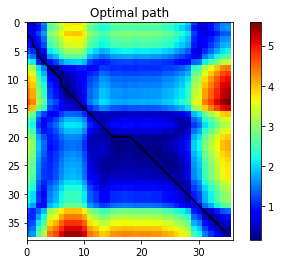

Cost of the optimal path: 23.431033325395077


In [12]:
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.colorbar()
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0], color='black', linewidth=1.5)

plt.xlim(0, D.shape[1])
plt.ylim(D.shape[0], 0)

plt.show()
print("Cost of the optimal path:", distance)

### Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

Let's take as a reference SIG_Rep_1_Number_0

In [13]:
file_path_1 = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)

#iterate it over the 12 Rep of number 0 in order to retrieve the 12 cepstral vectors
temp=np.inf
for i in range(2,13):
    file_path = "./Data/SIG/SIG_Rep_"+str(i)+"_Number_0.wav"
    sample_rate, wav_data = wavfile.read(file_path)
    cepstral_vectors = feature_extraction(
    wav_data, window_size, window_shift, cepstral_order)
    _, _, distance,_ = time_alignment(cepstral_vectors_1, cepstral_vectors, gamma=2)
    if distance < temp:
        temp = distance
        index = i
    print("Cost of the optimal path of Rep_"+str(i)+":", distance)
print("The most similar Rep is Rep_"+str(index)+" with a cost of the optimal path of:", temp)


Cost of the optimal path of Rep_2: 23.431033325395077
Cost of the optimal path of Rep_3: 21.489937146220683
Cost of the optimal path of Rep_4: 21.110033638868487
Cost of the optimal path of Rep_5: 21.889846369271492
Cost of the optimal path of Rep_6: 22.46896803005388
Cost of the optimal path of Rep_7: 24.37134849267392
Cost of the optimal path of Rep_8: 19.57341967365658
Cost of the optimal path of Rep_9: 22.893886386049076
Cost of the optimal path of Rep_10: 21.905862094771365
Cost of the optimal path of Rep_11: 20.09776288842495
Cost of the optimal path of Rep_12: 27.926434219450275
The most similar Rep is Rep_8 with a cost of the optimal path of: 19.57341967365658


### 1. Are the performances satisfactory ?


To assess the performance, I listened to the farthest version of 0 from the reference version (version 12) and the closest version (version 8). Even without having absolute pitch perception, I noticed a distinct difference in the ending of the pronunciation between these versions. 

Version 12 had a higher pitch at the end, while both the reference version and version 8 had a lower, more bass pitch.

Based on this observation, we can consider the performance satisfactory because the version that differed more from the others was also farther in terms of distance.

### 2. What is the influence of the γ choice

Let's try the case of gamma=1 and gamma=10 

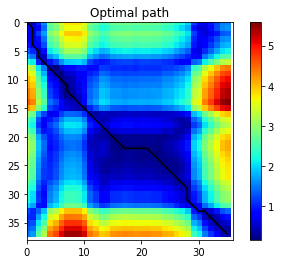

Cost of the optimal path: 14.892656240316784


In [14]:
### Gamma = 1 Path comparison
file_path_1 = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./Data/SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)
#np.set_printoptions(precision=4)
D, M, distance,C_D = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=1)

# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.colorbar()
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0], color='black', linewidth=1.5)

plt.xlim(0, D.shape[1])
plt.ylim(D.shape[0], 0)

plt.show()
print("Cost of the optimal path:", distance)


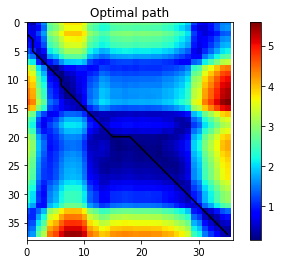

Cost of the optimal path: 26.6081336234383


In [15]:
### Gamma = 10 Path comparison
file_path_1 = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./Data/SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)
#np.set_printoptions(precision=4)
D, M, distance,C_D = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=10)

# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.colorbar()
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0], color='black', linewidth=1.5)

plt.xlim(0, D.shape[1])
plt.ylim(D.shape[0], 0)

plt.show()
print("Cost of the optimal path:", distance)


When γ is set to a higher value, it increases the weight of the diagonal path. This means that the algorithm prefers to align the elements along the diagonal of the cumulative distance matrix, promoting similar elements to be matched. A higher γ value can be beneficial when there is a high degree of similarity between the sequences being aligned. 

Conversely, when γ is set to a lower value, such as γ < 1, it reduces the weight of the diagonal path. This allows the algorithm to explore other alignment paths that may deviate from the diagonal, potentially accommodating larger local variations between the sequences. A lower γ value can be useful when there are significant local variations or distortions in the sequences.

The visualisation of the different path highlighted it well indeed when gamma is 10 we see a straight line for the paths whearase for gamma=1 we have more curvature. 

In [16]:
### Gamma=1 distance comparison
temp=np.inf
for i in range(2,13):
    file_path = "./Data/SIG/SIG_Rep_"+str(i)+"_Number_0.wav"
    sample_rate, wav_data = wavfile.read(file_path)
    cepstral_vectors = feature_extraction(
    wav_data, window_size, window_shift, cepstral_order)
    _, _, distance,_ = time_alignment(cepstral_vectors_1, cepstral_vectors, gamma=1)
    if distance < temp:
        temp = distance
        index = i
    print("Cost of the optimal path of Rep_"+str(i)+":", distance)
print("The most similar Rep is Rep_"+str(index)+" with a cost of the optimal path of:", temp)

Cost of the optimal path of Rep_2: 14.892656240316784
Cost of the optimal path of Rep_3: 13.533026331041555
Cost of the optimal path of Rep_4: 13.435823714480488
Cost of the optimal path of Rep_5: 13.087079529249877
Cost of the optimal path of Rep_6: 13.77576196721935
Cost of the optimal path of Rep_7: 14.02066039416119
Cost of the optimal path of Rep_8: 11.723780782383827
Cost of the optimal path of Rep_9: 13.367239031558764
Cost of the optimal path of Rep_10: 12.974821428315046
Cost of the optimal path of Rep_11: 12.036375462222779
Cost of the optimal path of Rep_12: 18.047569840901676
The most similar Rep is Rep_8 with a cost of the optimal path of: 11.723780782383827


In [17]:
### Gamma=10 distance comparison
temp=np.inf
for i in range(2,13):
    file_path = "./Data/SIG/SIG_Rep_"+str(i)+"_Number_0.wav"
    sample_rate, wav_data = wavfile.read(file_path)
    cepstral_vectors = feature_extraction(
    wav_data, window_size, window_shift, cepstral_order)
    _, _, distance,_ = time_alignment(cepstral_vectors_1, cepstral_vectors, gamma=10)
    if distance < temp:
        temp = distance
        index = i
    print("Cost of the optimal path of Rep_"+str(i)+":", distance)
print("The most similar Rep is Rep_"+str(index)+" with a cost of the optimal path of:", temp)

Cost of the optimal path of Rep_2: 26.6081336234383
Cost of the optimal path of Rep_3: 24.853078645724416
Cost of the optimal path of Rep_4: 24.553044897891045
Cost of the optimal path of Rep_5: 26.32597344547086
Cost of the optimal path of Rep_6: 25.414986771377478
Cost of the optimal path of Rep_7: 27.578936444837183
Cost of the optimal path of Rep_8: 22.872924094679583
Cost of the optimal path of Rep_9: 26.537530876106022
Cost of the optimal path of Rep_10: 26.660288601414518
Cost of the optimal path of Rep_11: 24.640528754118872
Cost of the optimal path of Rep_12: 31.51756042198766
The most similar Rep is Rep_8 with a cost of the optimal path of: 22.872924094679583


Regarding the influence on the distance. 

First, it does not change the results. Rep of 0 are still ordered the same way when we change gamma. Furthermore, the distance values obtained from the alignment paths do not show significant variations when different γ values are used. The distances consistently fall within a similar range, typically on the order of 10.

### 3. What implicit hypothesis is made when using the Euclidean distance

When using the Euclidean distance to measure the proximity of cepstral vectors, an implicit hypothesis is made that the Euclidean distance adequately captures the relevant acoustic similarity between the vectors. This assumption implies that similar acoustic patterns are represented by cepstral vectors that are close in Euclidean space.

However, when considering aligned sequences corresponding to different repetitions of the same word, this hypothesis may not be entirely acceptable. The differences between repetitions can arise from various factors such as variations in pronunciation, emphasis, or voice characteristics. These differences may lead to significant variations in the cepstral vectors, even for the same word.

One possible method to estimate an appropriate weighting for the comparison of cepstral vectors from aligned data is to analyze the statistical properties of the vectors within each aligned position. By examining the distribution of values for each position across different repetitions, we can gain insights into the discriminative power of specific cepstral coefficients.

Introducing a weighting scheme based on the statistical analysis of aligned data has the potential to improve discrimination performance. By assigning higher weights to cepstral coefficients that carry more discriminative information, the distance measure becomes more sensitive to the variations that are important for distinguishing between repetitions. 


## Evaluation of Speech Recognition

The goal of this part is to implement an evaluation strategy in order to check how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. Ideally, we would need to rotate the reference/unknown sets to perform cross-validation - but we can work with a random choice of only one reference for each number to simplify the setup. 
To do so, write a function ```classification```. For example, you can use the following formalism : 

```[confusion, accuracy] = classification(vectors, gamma)```

- ```vectors``` contains all the cepstral vectors for the signals in the chosen dataset. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.


- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate (averaged over cross-validation experiments if used).

In [35]:
random.seed(1)
#reference set we choose one ref for all data set 
ref_set = []
random_vector = [random.randint(1, 12) for _ in range(10)]
for i in range(0,10):
    file_path = "./Data/SIG/SIG_Rep_"+str(random_vector[i])+"_Number_"+str(i)+".wav"
    sample_rate, wav_data = wavfile.read(file_path)
    cepstral_vectors = feature_extraction(
    wav_data, window_size, window_shift, cepstral_order)
    ref_set.append(cepstral_vectors)



In [36]:
def classification(vectors,y_true,gamma): # we add y_true corresponding to the true labels of the vectors
    y_pred=[]
    for i in range(len(vectors)):
        temp=np.inf
        for j in range(len(ref_set)):
            _, _, distance,_ = time_alignment(ref_set[j], vectors[i], gamma=gamma)
            if distance < temp:
                temp = distance
                index = j
        y_pred.append(index)
    #confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #accuracy
    accuracy = accuracy_score(y_true, y_pred)
    return cm,accuracy

Questions: 
- Evaluate the speech recognition performance on the data ```SIG```, and then on the data ```SIG2```. Visualize the confusion matrices ? 
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Try to interpret the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose (shortly) possible solutions to these problems.

# Speech recognition

In [37]:
### ON SIG

vectors = []
y_true = []
for i in range(0,10):
    for j in range(0,12):
        file_path = "./Data/SIG/SIG_Rep_"+str(j+1)+"_Number_"+str(i)+".wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(
        wav_data, window_size, window_shift, cepstral_order)
        vectors.append(cepstral_vectors)
        y_true.append(i)

In [38]:
res=classification(vectors,y_true,2)
print("Confusion matrix:\n",res[0])
print("Accuracy:",res[1])

Confusion matrix:
 [[12  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  1  0  0 11  0  0]
 [ 0  0  0  0  0  0  1  0 11  0]
 [ 0  0  0  0  0  0  0  0  0 12]]
Accuracy: 0.9833333333333333


In [40]:
### ON SIG2
vectors = []
y_true = []
for i in range(0,10):
    for j in range(0,6):
        file_path = "./Data/SIG2/SIG2_Rep_"+str(j+1)+"_Number_"+str(i)+".wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(
        wav_data, window_size, window_shift, cepstral_order)
        vectors.append(cepstral_vectors)
        y_true.append(i)

In [41]:
res=classification(vectors,y_true,2)
print("Confusion matrix:\n",res[0])
print("Accuracy:",res[1])

Confusion matrix:
 [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 1 0 0 5 0 0]
 [0 0 0 0 0 0 1 0 5 0]
 [0 0 0 0 0 0 0 0 0 6]]
Accuracy: 0.9666666666666667


We remark that with our randomn choice of reference we have good accuracy for SIG et SIG2 above 95% and that in both we tend to mistaken on 7 and 8 which are replaced respectively by 4 and 6.

By listening to the audio files,  the SIG2 dataset and the SIG dataset are actually the same that's why we don't face the same problem as will follow when we don't take as a reference an audio from SIG2 to recognise number from SIG2

In [43]:
### ON SIGMIX

vectors = []
y_true = []
for i in range(0,10):
    for j in range(0,12):
        file_path = "./Data/SIGMIX/SIGMIX_Rep_"+str(j+1)+"_Number_"+str(i)+".wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(
        wav_data, window_size, window_shift, cepstral_order)
        vectors.append(cepstral_vectors)
        y_true.append(i)

In [44]:
res=classification(vectors,y_true,2)
print("Confusion matrix:\n",res[0])
print("Accuracy:",res[1])

Confusion matrix:
 [[ 6  6  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0]
 [ 0  6  6  0  0  0  0  0  0  0]
 [ 0  4  0  8  0  0  0  0  0  0]
 [ 0  2  0  0 10  0  0  0  0  0]
 [ 0  6  0  0  0  6  0  0  0  0]
 [ 0  3  3  0  0  0  6  0  0  0]
 [ 0  3  0  0  4  0  0  5  0  0]
 [ 0  0  0  0  1  0  1  0 10  0]
 [ 0  6  0  0  0  0  0  0  0  6]]
Accuracy: 0.625


Here we see that we have way less good accuracy than before when we try to recognize a number from a different voice than the one used as a ref. 

During this lab we saw that DTW recognize same speech with time distortion only when it's the same speaker wich apply the time distortion. Then it struggles from training Data Dependency: DTW typically requires a reference template or training data for alignment. This dependency on training data can limit its adaptability to unseen or variable speech patterns, as it may struggle with variations not present in the training set. 

We have also the fact that it depends on various hyperparamter such as gamma or the metric you choose to compute the distance. Of course we can use cross validation but it adds some complexity. 

Finally an issue that we did not face during this lab but we may expect is that the method alone without other techniques will be inneficient when we will want to recognize more complexe vocabulary than simple numbers. With some research the name of HMMs or DNNs can be effective added with DTW.